# Portfolio Optimization

We found good stocks or assets to invest however how should we optimize our portfolio containing multiple tickers, we could simply go equal amounts, but it doesn't guarantee good performance.

Here we'll be looking ways to optimize your portfolio with simple codes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

import seaborn as sns
sns.set()

In [18]:
tickers = ['GC=F', 'DOGE-USD', 'BTC-USD', 'ADA-USD']
startdate = '2017-10-01'
df = pdr.get_data_yahoo(tickers, start=startdate)['Adj Close']
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)
df

[*********************100%***********************]  4 of 4 completed


,ADA-USD,BTC-USD,DOGE-USD,GC=F
Date,,,,
2017-09-30,0.024969,4338.709961,0.001145,1272.699951
2017-10-01,0.024969,4403.740234,0.001084,1272.699951
2017-10-02,0.025932,4409.319824,0.001085,1272.699951
2017-10-03,0.020816,4317.479980,0.001108,1271.500000
2017-10-04,0.021931,4229.359863,0.001024,1273.699951
...,...,...,...,...
2021-05-22,1.463622,37536.632812,0.342371,1884.599976
2021-05-23,1.325436,34770.582031,0.308071,1884.599976
2021-05-24,1.549485,38705.980469,0.366162,1884.599976


### Calculate returns and risks

In [19]:
window = 252 # avg stock market open date

daily_ret = df.pct_change() # daily return
annual_ret = daily_ret.mean() * 252 # annual return (daily mean * 252 days)
daily_cov = daily_ret.cov() # daily risk is calculated with `cov()`, estimate covariance matrix
annual_cov = daily_cov * 252 # annual risk 

port_ret = []
port_risk = []
port_weight = []

In [20]:
daily_ret

,ADA-USD,BTC-USD,DOGE-USD,GC=F
Date,,,,
2017-09-30,NaN,NaN,NaN,NaN
2017-10-01,0.000000,0.014988,-0.053275,0.000000
2017-10-02,0.038568,0.001267,0.000923,0.000000
2017-10-03,-0.197285,-0.020829,0.021198,-0.000943
2017-10-04,0.053565,-0.020410,-0.075812,0.001730
...,...,...,...,...
2021-05-22,-0.057113,0.006217,-0.047334,0.004210
2021-05-23,-0.094414,-0.073689,-0.100184,0.000000
2021-05-24,0.169038,0.113182,0.188564,0.000000


In [21]:
annual_cov

,ADA-USD,BTC-USD,DOGE-USD,GC=F
ADA-USD,1.782953,0.441491,0.679457,0.011142
BTC-USD,0.441491,0.441540,0.405235,0.007393
DOGE-USD,0.679457,0.405235,3.143956,0.012884
GC=F,0.011142,0.007393,0.012884,0.015723


## Monte Carlo simulation

A Monte Carlo simulation is a model used to predict the probability of different outcomes when the intervention of random variables is present. Monte Carlo simulations help to explain the impact of risk and uncertainty in prediction and forecasting models.

Here we're going to create 20,000 different portfolio with different weights of each tickers.

In [22]:
for _ in range(20000): # for loop, use `_`  when ignoring index
    weights = np.random.random(len(tickers)) # create random number array
    weights /= np.sum(weights) # divide above random array by sum ,make it total 1
    
    returns = np.dot(weights, annual_ret) # multiply above portfolio weight array to annual return, gets total return
    # multiply annual covariance to weight array and multiply to weight array transpose. Finally `sqrt()` to get 
    # total risk of portfolio
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 
    
    # add 20,000 portfolio's returns, risk and weights to each list
    port_ret.append(returns)
    port_risk.append(risk)
    port_weight.append(weights)
    
portfolio = {'Returns': port_ret, 'Risk': port_risk}
for i, s in enumerate(tickers):
    portfolio[s] = [weight[i] for weight in port_weight]
df_port = pd.DataFrame(portfolio)
df_port = df_port[['Returns', 'Risk'] + [s for s in tickers]]

In [23]:
portfolio

{'Returns': [1.2510210517488636,
  0.8872494236388837,
  1.2164197624316977,
  1.2478402363339833,
  1.3066926856465884,
  1.260641777232562,
  0.8407678311352655,
  1.3387516543312727,
  1.0388425161264963,
  1.1464673701668873,
  1.573105202659457,
  1.042129827269478,
  1.285981669101957,
  0.9220280550906645,
  1.52172096049187,
  1.126387093869251,
  0.9284442714497076,
  1.5618234476280939,
  0.3134356490367148,
  1.149905998931275,
  1.0253443373207816,
  1.1479876656025385,
  1.1577884159274694,
  1.5575162703934968,
  0.9246856841719489,
  0.9069023923401553,
  1.0164594812265038,
  0.9922849161271461,
  1.3032004687805037,
  0.8773364561451589,
  0.9935569763433869,
  1.1140237074485446,
  0.817140263805798,
  1.3010268153227733,
  1.2385687269065249,
  1.0408031253963044,
  0.44572540578941994,
  1.3574465042664532,
  1.2406771105266645,
  1.0645582318215963,
  0.8706447994494894,
  1.4761859433184028,
  0.8433213255764911,
  1.0657406216523309,
  0.8354838164769386,
  1.624

In [24]:
df_port

,Returns,Risk,GC=F,DOGE-USD,BTC-USD,ADA-USD
0,1.251021,0.837531,0.375691,0.119631,0.272487,0.232192
1,0.887249,0.600330,0.222050,0.352529,0.139598,0.285823
2,1.216420,0.818323,0.264313,0.160459,0.325020,0.250208
3,1.247840,0.886773,0.183663,0.033510,0.434197,0.348629
4,1.306693,0.895556,0.263307,0.076960,0.393521,0.266212
...,...,...,...,...,...,...
19995,1.508995,1.163771,0.062489,0.171373,0.613737,0.152402
19996,1.309442,1.042036,0.029902,0.051095,0.571634,0.347369
19997,1.386164,0.933266,0.385659,0.089308,0.340602,0.184431
19998,0.799182,0.614571,0.294182,0.448395,0.017092,0.240331


Plot Monte Carlo simulation with `scatter()`

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


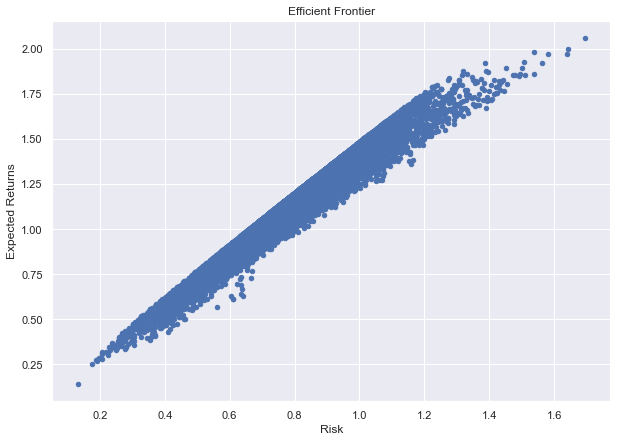

In [31]:
df_port.plot.scatter(x='Risk', y='Returns', figsize=(10,7), grid=True)
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

## Sharpe Ratio

The Sharpe ratio measures the performance of an investment (e.g., a security or portfolio) compared to a risk-free asset, after adjusting for its risk.

It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment (i.e., its volatility). It represents the additional amount of return that an investor receives per unit of increase in risk.

It was named after William F. Sharpe who developed it in 1966.

[*********************100%***********************]  4 of 4 completed


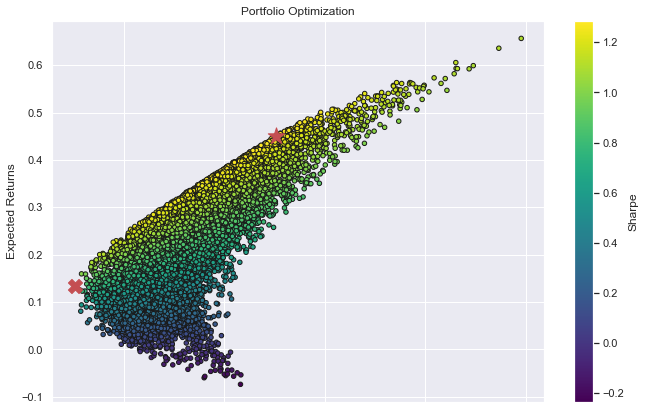

In [79]:
tickers = ['SPY', 'QLD', 'USO','BTC-USD']
startdate = '2014-10-01'
df = pdr.get_data_yahoo(tickers, start=startdate)['Adj Close']
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

window = 252 # avg stock market open date

daily_ret = df.pct_change() # daily return
annual_ret = daily_ret.mean() * 252 # annual return (daily mean * 252 days)
daily_cov = daily_ret.cov() # daily risk is calculated with `cov()`, estimate covariance matrix
annual_cov = daily_cov * 252 # annual risk 

port_ret = []
port_risk = []
port_weight = []
sharpe_ratio = []

for _ in range(20000): # for loop, use `_`  when ignoring index
    weights = np.random.random(len(tickers)) # create random number array
    weights /= np.sum(weights) # divide above random array by sum ,make it total 1
    
    returns = np.dot(weights, annual_ret) # multiply above portfolio weight array to annual return, gets total return
    # multiply annual covariance to weight array and multiply to weight array transpose. Finally `sqrt()` to get 
    # total risk of portfolio
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 
    
    # add 20,000 portfolio's returns, risk and weights to each list
    port_ret.append(returns)
    port_risk.append(risk)
    port_weight.append(weights)
    sharpe_ratio.append(returns/risk) # Sharpe ratio
    
portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe': sharpe_ratio}
for i, s in enumerate(tickers):
    portfolio[s] = [weight[i] for weight in port_weight]
df_port = pd.DataFrame(portfolio)
df_port = df_port[['Returns', 'Risk', 'Sharpe'] + [s for s in tickers]]

max_sharpe = df_port.loc[df_port['Sharpe'] == df_port['Sharpe'].max()]
min_risk = df_port.loc[df_port['Risk'] == df_port['Risk'].min()]

df_port.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis', # By sharpe ratio colormap to `viridis`
                edgecolors='k', figsize=(11,7), grid=True)
plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r',
           marker='*', s=300) # Make red * max sharpe ratio 
plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='r',
           marker='X', s=200) # Make Min risk red `X` 
plt.title('Portfolio Optimization')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

In [77]:
max_sharpe

,Returns,Risk,Sharpe,SPY,QLD,USO,BTC-USD
5812,0.441882,0.345053,1.280619,0.444151,0.480956,0.073858,0.001035


In [78]:
min_risk

,Returns,Risk,Sharpe,SPY,QLD,USO,BTC-USD
2456,0.102028,0.150599,0.67748,0.035568,0.007783,0.859799,0.096851
